In [1]:
import abc
import datetime
import timeit
from dataclasses import dataclass
from typing import Literal, Optional

import matplotlib.colors as clr
import matplotlib.pyplot as plt
import torch
import torch.backends.cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.version
from torch import Tensor

from model.pixelcnn import PixelCNN
from modules.df_attention import DfAttention
from modules.df_conv2d import DfConv2d
from modules.df_elemwise import DfElemwise
from modules.df_module import check_pixel_parity
from modules.df_residualize import DfResidualize
from modules.df_sequential import DfSequential


In [2]:
dtype = torch.float32
device = "cuda"
opts = {"dtype1": dtype, "dtype2": dtype, "device1": device, "device2": device}

mod = PixelCNN(1, 64)
check_pixel_parity(mod, (1, 28, 28), **opts, batch_size=1)

PixelCNN
Equal 3.81%
Close 81.87%
MaxDiff 2.32e-02
A:
 Range [-2.67e+02, 2.41e+02]
 Mean -4.00e+00
 Var 5.80e+03    
B:
 Range [-2.67e+02, 2.41e+02]
 Mean -4.00e+00
 Var 5.80e+03    
Diff:
 Range [-1.77e-02, 2.32e-02]
 Mean 2.99e-05
 Var 6.94e-06    




In [3]:
@torch.no_grad()
def sample(
    depth_first: bool,
    device: str = "cuda",
    dtype: torch.dtype = torch.float32,
    batch_size: int = 16,
    img_size: int = 28,
    in_channels: int = 1,
    hidden_channels: int = 64,
    num_classes: int = 256,
    kernel_size: int = 3,
    seed: Optional[int] = None,
) -> tuple[Tensor, int]:
    if seed == None:
        seed = torch.seed()
    else:
        torch.manual_seed(seed)

    img = (
        torch.randint(
            0,
            num_classes,
            (1, in_channels, img_size, img_size),
            dtype=dtype,
            device=device,
        )
        / num_classes
    ).repeat(batch_size, 1, 1, 1)

    model = PixelCNN(
        in_channels, hidden_channels, kernel_size=kernel_size, num_classes=num_classes
    ).to(device=torch.device(device), dtype=dtype)

    for y in range(img_size):
        for x in range(img_size):
            pos = (y, x) if depth_first else None
            o = model(img, pos=pos)

            px = o[..., y, x].view(batch_size, in_channels, num_classes).argmax(-1)

            img[..., y, x] = px
    # img = model.sample(shape=(batch_size, in_channels, img_size, img_size), depth_first=depth_first)

    plt.imshow(img[0].to(torch.float32).permute(1, 2, 0).cpu(), norm=clr.Normalize())
    return img, seed


In [4]:
# Just abstracting some stuff to make timed sampling convenient


@dataclass
class Ctx:
    img: Optional[Tensor] = None
    seed: Optional[int] = None


ctx = Ctx()


def get_callable(depth_first: bool, ctx: Ctx = ctx, **kwargs):
    def call():
        ctx.img, ctx.seed = sample(depth_first=depth_first, seed=ctx.seed, **kwargs)

    return call


def tsdelta(seconds: float) -> datetime.timedelta:
    return datetime.datetime.fromtimestamp(seconds) - datetime.datetime.fromtimestamp(0)


def strfdelta(tdelta: datetime.timedelta | float, fmt: str) -> str:
    if isinstance(tdelta, (float, int)):
        tdelta = tsdelta(tdelta)
    hours, rem = divmod(tdelta.seconds, 60 * 60)
    minutes, seconds = divmod(rem, 60)
    return fmt.format(d=tdelta.days, h=hours, m=minutes, s=seconds)


def fmttime(time: float) -> str:
    return strfdelta(time, "{h:02}:{m:02}:{s:02}")


#### Depth First

Runs the sampler depth-first

Sample took 00:00:17 to complete


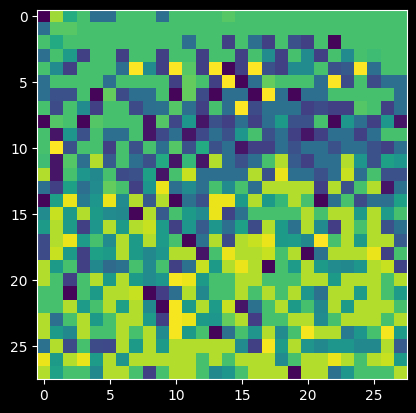

In [5]:
time = timeit.timeit(get_callable(True, batch_size=16, img_size=28), number=1)
img_d = ctx.img
print(f"Sample took {fmttime(time)} to complete")


#### Breadth First

Runs the sampler breadth-first

We'll use a smaller batch size here, because we can't handle as much. Besides, less is more.

Sample took 00:00:18 to complete


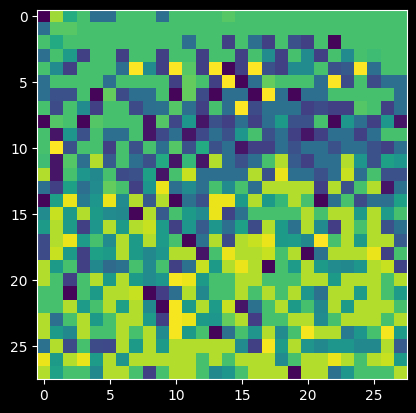

In [6]:
time = timeit.timeit(get_callable(False, batch_size=16, img_size=28), number=1)
img_b = ctx.img
print(f"Sample took {fmttime(time)} to complete")


#### Verify Parity

Verifies the parity between the depth-first and breadth-first methods.

PyTorch may process slices vs complete batches slightly differently, leading to minor differences in output at each layer. These differences will accumulate through the forward pass and cause the 2 methods to diverge if the depth-first approach doesn't have a large enough batch-size / channel depth.

> In particular, let A and B be 3D tensors with the dimensions suitable for batched matrix multiplication. Then (A@B)[0] (the first element of the batched result) is not guaranteed to be bitwise identical to A[0]@B[0] (the matrix product of the first elements of the input batches) even though mathematically it’s an identical computation.
>
> https://pytorch.org/docs/stable/notes/numerical_accuracy.html#batched-computations-or-slice-computations



In [7]:
assert img_d is not None and img_b is not None

img_d = img_d[0].repeat(img_b.shape[0], 1, 1, 1)
if torch.equal(img_d, img_b):
    print("Samples are exactly equal!")
elif torch.allclose(img_d, img_b):
    print("Samples are close enough according to PyTorch defaults!")
else:
    print("Samples are not close!")
    plt.imshow(
        torch.isclose(img_d, img_b).all(0).all(0, keepdim=True).permute(1, 2, 0).cpu(),
        norm=clr.Normalize(),
    )


Samples are exactly equal!
